323480 texts are found in train.csv
80871 texts are found in test.csv
85537 unique tokens are found
Shape of train data tensor: (323480, 40)
Shape of train labels tensor: (323480,)
Shape of test data tensor: (80871, 40)
Shape of test ids tensor: (80871,)
Epoch 1/10
569/569 [==============================] - 177s 311ms/step - loss: 0.2695 - acc: 0.8160 - f1: 0.6702 - val_loss: 0.3508 - val_acc: 0.8501 - val_f1: 0.7628
Epoch 2/10
569/569 [==============================] - 177s 312ms/step - loss: 0.2285 - acc: 0.8435 - f1: 0.7403 - val_loss: 0.3233 - val_acc: 0.8653 - val_f1: 0.7964
Epoch 3/10
569/569 [==============================] - 177s 311ms/step - loss: 0.2175 - acc: 0.8514 - f1: 0.7567 - val_loss: 0.3128 - val_acc: 0.8685 - val_f1: 0.8041
Epoch 4/10
569/569 [==============================] - 176s 309ms/step - loss: 0.2109 - acc: 0.8551 - f1: 0.7643 - val_loss: 0.3028 - val_acc: 0.8712 - val_f1: 0.8085
Epoch 5/10
569/569 [==============================] - 177s 311ms/step - loss: 0.2

Text(0, 0.5, 'f1 score')

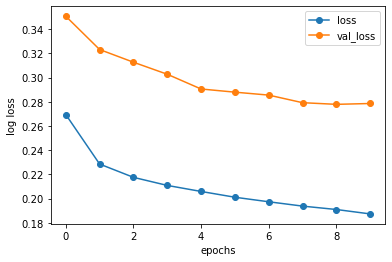

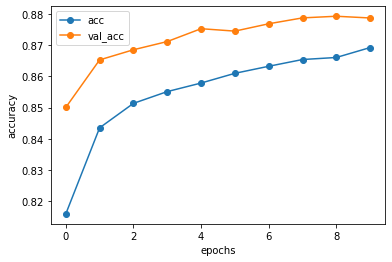

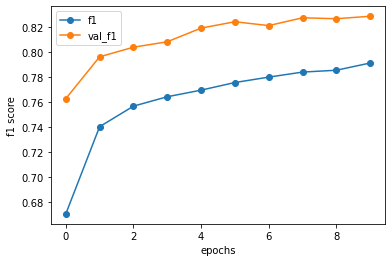

In [3]:

# Libraries
import os
import re
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Embedding, Dropout, Activation, LSTM, Lambda
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.pooling import GlobalAveragePooling1D
import keras.backend as K
from math import pow, floor
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Data set path
Data_Dir = '../input/quora-question-pairs/'

# Train_data & test_data
Train_Data_File = Data_Dir + 'train.csv'
Test_Data_File = Data_Dir + 'test.csv'

# Sequence length
Max_Sequence_Length = 40

# The max-number of words for segmentation
Max_Num_Words = 100000

# Dimensions of embedding
Embedding_Dim = 300

# Validation set ratio
Validation_Split_Ratio = 0.1

# The parameters of lstm and FC layers
Num_Lstm = 256
Num_Dense = 125
Rate_Drop_Lstm = 0.15
Rate_Drop_Dense = 0.15


# Avtivation function
act_f = 'relu'

# Data processing
# To get the train data
df_train = pd.read_csv(Train_Data_File, encoding='utf-8')
df_train = df_train.fillna('empty')
train_texts_1 = df_train.question1.tolist()
train_texts_2 = df_train.question2.tolist()
train_labels = df_train.train_labels.values

print('{} texts are found in train.csv'.format(len(train_texts_1)))

# To get the test data
df_test = pd.read_csv(Test_Data_File, encoding='utf-8')
df_test = df_test.fillna('empty')
test_texts_1 = df_test.question1.tolist()
test_texts_2 = df_test.question2.tolist()
test_labels = df_test.train_labels.values

print('{} texts are found in test.csv'.format(len(test_texts_1)))

# Encoding the setence and segmentation
tokenizer = Tokenizer(num_words=Max_Num_Words)
tokenizer.fit_on_texts(train_texts_1 + train_texts_2 + test_texts_1 + test_texts_2)

train_sequences_1 = tokenizer.texts_to_sequences(train_texts_1)
train_sequences_2 = tokenizer.texts_to_sequences(train_texts_2)
test_sequences_1 = tokenizer.texts_to_sequences(test_texts_1)
test_sequences_2 = tokenizer.texts_to_sequences(test_texts_2)

word_index = tokenizer.word_index
print('{} unique tokens are found'.format(len(word_index)))

# Sentence padding for train_data
train_data_1 = pad_sequences(train_sequences_1, maxlen=Max_Sequence_Length)
train_data_2 = pad_sequences(train_sequences_2, maxlen=Max_Sequence_Length)

print('Shape of train data tensor:', train_data_1.shape)
print('Shape of train labels tensor:', train_labels.shape)

# Sentence padding for test_data
test_data_1 = pad_sequences(test_sequences_1, maxlen=Max_Sequence_Length)
test_data_2 = pad_sequences(test_sequences_2, maxlen=Max_Sequence_Length)

print('Shape of test data tensor:', test_data_2.shape)
print('Shape of test ids tensor:', test_labels.shape)


# Features extraction
questions = pd.concat([df_train[['question1', 'question2']], \
                       df_test[['question1', 'question2']]], axis=0).reset_index(drop='index')

q_dict = defaultdict(set)
for i in range(questions.shape[0]):
    q_dict[questions.question1[i]].add(questions.question2[i])
    q_dict[questions.question2[i]].add(questions.question1[i])

# The length of qusetion sequence
def q1_freq(row):
    return (len(q_dict[row['question1']]))

def q2_freq(row):
    return (len(q_dict[row['question2']]))

# Sequence similarity feature
def q1_q2_intersect(row):
    return (len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

# Leaks feature
df_train['q1_q2_intersect'] = df_train.apply(q1_q2_intersect, axis=1, raw=True)
df_train['q1_freq'] = df_train.apply(q1_freq, axis=1, raw=True)
df_train['q2_freq'] = df_train.apply(q2_freq, axis=1, raw=True)

df_test['q1_q2_intersect'] = df_test.apply(q1_q2_intersect, axis=1, raw=True)
df_test['q1_freq'] = df_test.apply(q1_freq, axis=1, raw=True)
df_test['q2_freq'] = df_test.apply(q2_freq, axis=1, raw=True)

leaks = df_train[['q1_q2_intersect', 'q1_freq', 'q2_freq']]
test_leaks = df_test[['q1_q2_intersect', 'q1_freq', 'q2_freq']]

# Data standardization
ss = StandardScaler()
ss.fit(np.vstack((leaks, test_leaks)))
leaks = ss.transform(leaks)
test_leaks = ss.transform(test_leaks)


# Word vectorization

# The max number of words
num_words = min(Max_Num_Words, len(word_index)) + 1

def get_model():

    # The embedding layer containing the word vectors

    emb_layer = Embedding(
        input_dim=num_words,
        output_dim=Embedding_Dim,
        input_length=Max_Sequence_Length,
        trainable=False
    )

    # LSTM layer

    lstm_layer = LSTM(Num_Lstm, dropout=Rate_Drop_Lstm, recurrent_dropout=Rate_Drop_Lstm)

    # Define inputs
    seq1 = Input(shape=(Max_Sequence_Length,), dtype='int32')
    seq2 = Input(shape=(Max_Sequence_Length,), dtype='int32')

    # Run inputs through embedding
    emb1 = emb_layer(seq1)
    emb2 = emb_layer(seq2)

    # Run through LSTM layers
    lstm_a = lstm_layer(emb1)
    lstm_b = lstm_layer(emb2)

    magic_input = Input(shape=(leaks.shape[1],))
    # magic_dense = BatchNormalization()(magic_input)
    magic_dense = Dense(int(Num_Dense / 2), activation=act_f)(magic_input)

    diff = Lambda(lambda x: K.abs(x[0]-x[1]))([lstm_a, lstm_b])
    mul = Lambda(lambda x: (x[0]*x[1]))([lstm_a, lstm_b])

    merged = concatenate([lstm_a, lstm_b, magic_dense, diff, mul])
    # merged = BatchNormalization()(merged)
    merged = Dropout(Rate_Drop_Dense)(merged)

    merged = Dense(Num_Dense, activation=act_f)(merged)
    # merged = BatchNormalization()(merged)
    merged = Dropout(Rate_Drop_Dense)(merged)

    preds = Dense(1, activation='sigmoid')(merged)



    # Train the model

    model = Model(inputs=[seq1, seq2, magic_input], outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', f1])

    # Set early stopping (large patience should be useful)
    return model


model = get_model()
# Set early stopping (large patience should be useful)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# The model save path
bst_model_path = 'model-params.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

# Set the class_weight for directional training
class_weight = {0: 1.309033281, 1: 0.471544715}


hist = model.fit([train_data_1, train_data_2, leaks], train_labels,
                 # validation_data=({
                 #                     'input_1': test_data_1, 
                 #                     'input_2': test_texts_2, 
                 #                     'input_3': test_leaks}, test_labels),
                 validation_split=0.1,
                 epochs=50, batch_size=512, shuffle=True,
                 class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])


model.save('t3.h5')

# Export report
report = pd.DataFrame(hist.history)
report.to_excel('report.xlsx', index=False)


report[['loss', 'val_loss']].plot(marker='o')
plt.xlabel('epochs')
plt.ylabel('log loss')


report[['acc', 'val_acc']].plot(marker='o')
plt.xlabel('epochs')
plt.ylabel('accuracy')

report[['f1', 'val_f1']].plot(marker='o')
plt.xlabel('epochs')
plt.ylabel('f1 score')